# CORD-19 AuthorRank

An example of how AuthorRank can be applied to datasets that contain authorship information about documents, like the [CORD-19](https://www.semanticscholar.org/cord19) dataset. 

## Imports

In [1]:
import author_rank as ar
import json
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import random

## Read Data

In [2]:
cord_df = pd.read_csv("../data/CORD-19/2020-07-16/metadata.csv", low_memory=False)

In [3]:
cord_df.sample(frac=1.).head(10)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
76549,oec08qv3,NaN,MedRxiv,Advice from a systems-biology model of the Cor...,10.1101/2020.03.29.20045039,NaN,NaN,medrxiv,Using standard systems biology methodologies a...,2020-03-30,"Westerhoff, Hans V; Kolodkin, Alexey N",NaN,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.1101/2020.03.29.20045039,216484972.0
81804,u9u0y5ju,NaN,Medline,Crystal structure of aminopeptidase N (proteob...,NaN,NaN,16885166,unk,Aminopeptidase N from Escherichia coli is a br...,2006,"Ito, Kiyoshi; Nakajima, Yoshitaka; Onohara, Yu...",The Journal of biological chemistry,NaN,NaN,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/pubmed/16885166/,5303207.0
122907,j0xbxbj4,NaN,WHO,Coronavirus disease 2019 (COVID-19) in childre...,NaN,NaN,NaN,unk,BACKGROUND: To assess the overall prevalence o...,2020,"Mantovani, Alessandro; Rinaldi, Elisabetta; Zu...",Pediatr. res,NaN,#32555539,NaN,NaN,NaN,NaN,219900362.0
163821,3x8napc9,NaN,Elsevier; Medline; PMC,Complementation and recombination between Alfa...,10.1016/0042-6822(91)91002-x,PMC7173233,1853571,els-covid,Abstract Deletions were made in an infectious ...,1991-08-31,"van der Kuyl, Antoinette C.; Neeleman, Lyda; B...",Virology,NaN,NaN,NaN,NaN,NaN,https://api.elsevier.com/content/article/pii/0...,31024823.0
60544,6ylxsltd,NaN,Medline,Apolipoprotein D Internalization Is a Basigin-...,10.1074/jbc.m115.644302,NaN,25918162,unk,"Apolipoprotein D (apoD), a member of the lipoc...",2015,"Najyb, Ouafa; Brissette, Louise; Rassart, Eric",The Journal of biological chemistry,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.1074/jbc.m115.644302; https...,205350313.0
129268,cafoic4y,NaN,WHO,What Is the Appropriate Use of Laparoscopy ove...,NaN,NaN,NaN,unk,"INTRODUCTION: Among surgeons worldwide, a conc...",2020,"Vigneswaran, Yalini; Prachand, Vivek N; Posner...",J. gastrointest. surg,NaN,#46025,NaN,NaN,NaN,NaN,215746580.0
80200,wgsjxck1,NaN,Medline,Enhanced surveillance and investigation of cor...,NaN,NaN,23888796,unk,Following the discovery in September 2012 of 2...,2013,"Pebody, R G; Nicoll, A; Buchholz, U; Zambon, M...",Eastern Mediterranean health journal = La revu...,NaN,NaN,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/pubmed/23888796/,14277113.0
104549,zeqfthvq,NaN,WHO,The COVID-19 and Cancer Consortium: A Collabor...,NaN,NaN,NaN,unk,National and international consortia will play...,2020,"Rubinstein, Samuel M; Steinharter, John A; War...",Cancer Cell,NaN,#395668,NaN,NaN,NaN,NaN,216588751.0
84367,c7ia2d5v,NaN,Medline,In vitro and in ovo expression of chicken gamm...,NaN,NaN,12719562,unk,Coronavirus defective RNAs (D-RNAs) have been ...,2003,"Hackney, Karen; Cavanagh, Dave; Kaiser, Pete; ...",Journal of virology,NaN,NaN,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/pubmed/12719562/,7317320.0
178583,68hgxqrn,e8ae86b48db5e9860652f9c78c61f13c1b41c700,Medline; PMC,Zinc Chelation Specifically Inhibits Early Sta...,10.3389/fimmu.2019.02347,PMC6779808,31632411,cc-by,Zinc is an essential micronutrient which regul...,2019-10-01,"Kar, Meenakshi; Khan, Naseem Ahmed; Panwar, Al...",Front Immunol,NaN,NaN,NaN,document_parses/pdf_json/e8ae86b48db5e9860652f...,document_parses/pmc_json/PMC6779808.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/31632411/;...,203604971.0


In [4]:
cord_df.shape

(192509, 19)

### Subsetting the Data 

Facilitate a "search" by restricting to documents that feature the word "bronchiolitis".

In [5]:
cord_df_search = cord_df[cord_df["title"].astype(str).str.contains("bronchiolitis")]

In [6]:
cord_df_search.shape

(138, 19)

In [7]:
authors_by_document = cord_df_search["authors"].astype(str).apply(
    lambda row: [r.strip() for r in row.split(";")]
)

In [8]:
documents = list()
for doc in authors_by_document:
    doc_dict = {
        "authors": list()
    }
    for auth in doc:
        doc_dict["authors"].append(
            {"name": auth} # cord 19 has full name as represented on document
        )
    documents.append(doc_dict)

## Fit AuthorRank

In [9]:
# create an AuthorRank object
ar_graph = ar.Graph()

In [10]:
documents[0:10]

[{'authors': [{'name': 'Liet, Jean-Michel'},
   {'name': 'Dejode, Jean-Marc'},
   {'name': 'Joram, Nicolas'},
   {'name': 'Roux, Bénédicte Gaillard-Le'},
   {'name': 'Bétrémieux, Pierre'},
   {'name': 'Rozé, Jean-Christophe'}]},
 {'authors': [{'name': 'Cruces, Pablo'},
   {'name': 'González-Dambrauskas, Sebastián'},
   {'name': 'Quilodrán, Julio'},
   {'name': 'Valenzuela, Jorge'},
   {'name': 'Martínez, Javier'},
   {'name': 'Rivero, Natalia'},
   {'name': 'Arias, Pablo'},
   {'name': 'Díaz, Franco'}]},
 {'authors': [{'name': 'Robinson, Lacey B.'},
   {'name': 'Chen Arroyo, Anna J.'},
   {'name': 'Dantas, Marina A.S.'},
   {'name': 'Espinola, Janice A.'},
   {'name': 'Sullivan, Ashley F.'},
   {'name': 'Camargo, Carlos A.'}]},
 {'authors': [{'name': 'Bressan, Silvia'},
   {'name': 'Balzani, Marco'},
   {'name': 'Krauss, Baruch'},
   {'name': 'Pettenazzo, Andrea'},
   {'name': 'Zanconato, Stefania'},
   {'name': 'Baraldi, Eugenio'}]},
 {'authors': [{'name': 'Patel, N. R.'},
   {'name':

In [11]:
# fit to the data
ar_graph.fit(
    documents=random.sample(documents, 25), # limit to a small number of documents
    progress_bar=True, # use a progress bar to indicate how far along processing is
    authorship_key="authors",
    keys=set(["name"]),
)

[ ================================================================= ] 97.95%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Show the Scores

In [12]:
# get the top authors for a set of documents
top = ar_graph.top_authors(
    normalize_scores=True,
    n=10
)

In [13]:
# print the results
for i, j in zip(top[0], top[1]):
    print(i, j)

('Piedra, Pedro A',) 1.0
('Calvo, Cristina',) 0.5565933980766243
('García-García, María Luz',) 0.5565933980766243
('Camargo, Carlos A',) 0.4212053568885412
('Mansbach, Jonathan M',) 0.4212053568885412
('Alverson, Brian K',) 0.0
('Baley, Jill E',) 0.0
('Brown, Mark A',) 0.0
('Gadomski, Anne M',) 0.0
('Hernandez-Cancio, Sinsi',) 0.0


## Visualize

In [14]:
G = ar_graph.graph

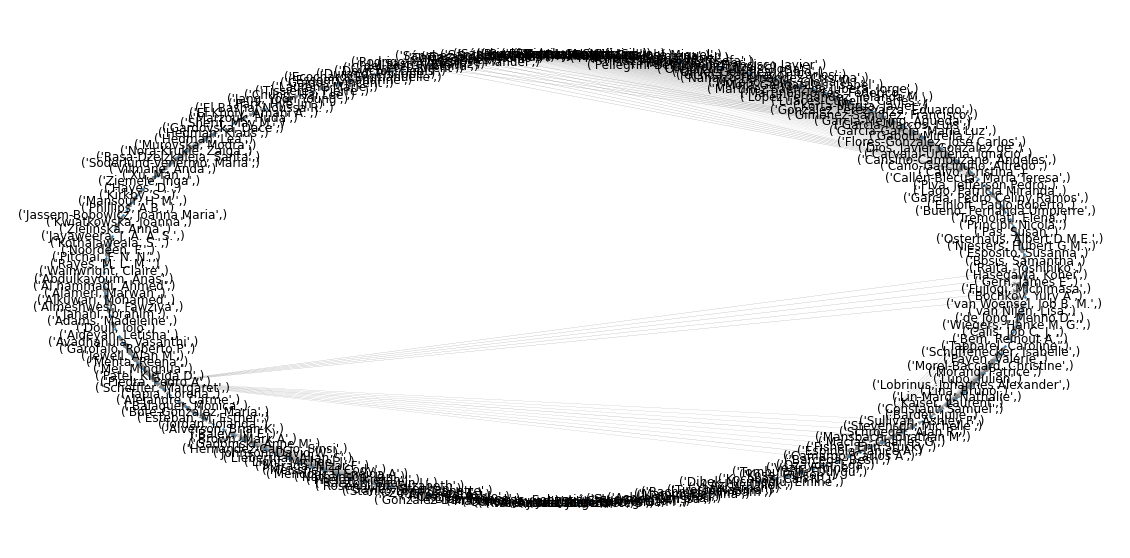

In [15]:
plt.figure(figsize=(20,10))
plt.axis('off')
pos = nx.shell_layout(G)
edgewidth = [d['weight'] for (u,v,d) in G.edges(data=True)]
edgewidth = [d for d in edgewidth]
author_scores = list()
for i in G.nodes:
    try:
        index = top[0].index(i)
        author_scores.append(top[1][index])
    except ValueError:
        pass
        
nx.draw_networkx_nodes(G, pos, node_size=2)
nx.draw_networkx_edges(G, pos, width=edgewidth, edge_color="grey")
nx.draw_networkx_labels(G, pos=pos)

plt.show()

In [16]:
G_json = ar_graph.as_json()

In [17]:
with open("../visualization/data/cord_graph.json", 'w') as f_out:
    json.dump(G_json, f_out)

In [18]:
scores_json = dict()
for t in zip(top[0], top[1]):
    scores_json[" ".join(t[0])] = t[1]
scores_json

{'Piedra, Pedro A': 1.0,
 'Calvo, Cristina': 0.5565933980766243,
 'García-García, María Luz': 0.5565933980766243,
 'Camargo, Carlos A': 0.4212053568885412,
 'Mansbach, Jonathan M': 0.4212053568885412,
 'Alverson, Brian K': 0.0,
 'Baley, Jill E': 0.0,
 'Brown, Mark A': 0.0,
 'Gadomski, Anne M': 0.0,
 'Hernandez-Cancio, Sinsi': 0.0}

In [19]:
with open("../visualization/data/cord_scores.json", 'w') as f_out:
    json.dump(scores_json, f_out)